In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.utils import resample
import numpy as np
np.random.seed(2017) # set random seed value to get reproducible results
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
# CONTROLS

grouping = 'stimulants'
#grouping = 'opioids'

outcome = 'engage30'

In [3]:
df = pd.read_csv(grouping + '.csv', index_col=[0]) # read in patient data
print(df.shape)
df.head()

(3328, 34)


,engage30,female_cd,unemplmt_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,und15_cd,CWSg_0_cd,srprobg_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,SFSg_0_cd,B2a_0g,Raceg4_cd_gr_1,Raceg4_cd_gr_2,Raceg4_cd_gr_3,Raceg4_cd_gr_4,pop_deng,%_unemployedg,%_public_assistanceg,%_povertyg
0,0,0,0,0,0,1,0,2,1,0,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,0,1,0,0,0,2.0,1.0,1.0,1.0
1,0,0,0,1,0,1,2,2,1,0,1,1,1,1,1,2,0,2,1,1,1,1,2,0,0,0,1,0,0,0,2.0,1.0,1.0,1.0
2,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,0,2,1,2,0,1,2,1,0,0,1,0,0,0,2.0,0.0,1.0,1.0
3,1,0,0,0,1,0,2,2,1,0,1,1,1,0,2,2,0,2,2,2,0,0,2,1,0,0,1,0,0,0,2.0,1.0,1.0,2.0
4,0,0,0,0,1,1,1,2,1,0,1,1,1,1,2,2,0,2,2,2,0,1,2,1,0,0,1,0,0,0,2.0,0.0,1.0,1.0


In [4]:
# cast socioeconomic data as integers

df = df.astype({'pop_deng': 'int64', '%_unemployedg': 'int64', '%_public_assistanceg': 'int64', '%_povertyg': 'int64'})

In [5]:
df.drop(columns=['epsg_0_cd'], inplace=True) # since dssg and epsg are correlated
df.shape

(3328, 33)

In [6]:
df[outcome].value_counts() # 1 represents a patient who did not engage

0    2178
1    1150
Name: engage30, dtype: int64

In [7]:
X = df.drop(columns=[outcome])
y = df[outcome]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2017)
print('Dataset sizes', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Training set outcome counts:\n', y_train.value_counts().to_frame())

Dataset sizes (2496, 32) (832, 32) (2496,) (832,)
Training set outcome counts:
    engage30
0      1642
1       854


In [8]:
# upsample minority class ***in training data only*** to combat outcome class imbalance and small dataset

train_data = pd.concat([X_train, y_train], axis=1) # combine training data back for resampling
negative = train_data[train_data[outcome] == 0] # separate majority...
positive = train_data[train_data[outcome] == 1] # ...and minority class

# upsample minority
pos_upsampled = resample(positive, 
                           replace=True, # sample with replacement
                           n_samples=len(negative)) # match number in majority class

# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])
X_train = upsampled.drop(columns=[outcome])
y_train = upsampled[outcome]

print('Upsampled dataset sizes', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Upsampled training set outcome counts:\n', y_train.value_counts().to_frame())

Upsampled dataset sizes (3284, 32) (832, 32) (3284,) (832,)
Upsampled training set outcome counts:
    engage30
1      1642
0      1642


In [9]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)

    print("Test Set Accuracy:", round(accuracy, 4))
    print("Test Set F1:", round(f1, 4))
    print("Test Set Precision:", round(precision, 4))
    print("Test Set Recall:", round(recall, 4))
    print("Test Set AUC:", round(auc, 4))
    return [accuracy, f1, precision, recall, auc]

In [10]:
# takes about 30 seconds for stimulants

def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all(): # if non-binary
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = pd.concat([result, one_hot], axis=1)
    #print('Logistic Regression Features:', result.columns)
    return result

def train_logisitc_regression(X_train, y_train):
    lr = LogisticRegression()
        
    # inverse strength of regularization
    C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    # class weights (John knows more about what this does...)
    class_weight = ['balanced', 'balanced_subsample', None]
    # maximum iterations to perform before failing to converge
    max_iter = [500, 1000, 5000, 10000]
    
    # Create the parameter grid
    param_grid = {'C': C,
                  'class_weight': class_weight,
                  'max_iter': max_iter}
    
    CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, verbose=1)
    CV_lr.fit(X_train_lr, y_train)
    
    print('Best Parameters:', CV_lr.best_params_)
    print('Best Training Score:', CV_lr.best_score_, '\n')
    return CV_lr.best_estimator_
    
    
X_train_lr = get_logistic_regression_features(X_train)
X_test_lr = get_logistic_regression_features(X_test)

lr = train_logisitc_regression(X_train_lr, y_train)
lr_perf = test_model(lr, X_test_lr, y_test)
lr_perf.insert(0, 'LR') # add label for performance table

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters: {'C': 0.7, 'class_weight': 'balanced', 'max_iter': 500}
Best Training Score: 0.5867844414745517 

Test Set Accuracy: 0.6022
Test Set F1: 0.5023
Test Set Precision: 0.4526
Test Set Recall: 0.5642
Test Set AUC: 0.5937


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   16.7s finished


In [11]:
haz_ratios = np.exp(lr.coef_[0])
feature_importance_lr = pd.DataFrame({'feature': X_test_lr.columns, 'LR-Hazards': haz_ratios})
feature_importance_lr['mag-from-1'] = abs(feature_importance_lr['LR-Hazards'] - 1)
feature_importance_lr.sort_values(by='mag-from-1', ascending=False)

,feature,LR-Hazards,mag-from-1
50,%_povertyg_0,1.919920,0.919920
48,%_public_assistanceg_0,0.405699,0.594301
49,%_public_assistanceg_2,0.504225,0.495775
16,TMIg_0_cd_2,1.490186,0.490186
39,SFSg_0_cd_0,1.484227,0.484227
46,%_unemployedg_0,0.534274,0.465726
1,unemplmt_cd,1.400103,0.400103
33,lrig_0_cd_0,1.393998,0.393998
18,SESg_0_cd_2,1.378351,0.378351
45,pop_deng_2,0.666795,0.333205


In [12]:
# takes about 13 hours for stimulants

def train_random_forest(X_train, y_train):
    rfc = RandomForestClassifier()
    # Number of trees in random forest
    n_estimators = [100, 200, 500, 1000, 2000]
    #n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = [None, 'log2', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [2, 5, 8, 10]
    #max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [5, 10, 15, 20]
    #min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # class weights (John knows more about what this does...)
    class_weight = ['balanced', 'balanced_subsample', None]
    
    # Create the parameter grid
    param_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap,
                  'class_weight': class_weight}
        
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1)
    CV_rfc.fit(X_train, y_train)
    print('Best Parameters:', CV_rfc.best_params_)
    print('Best Score:', CV_rfc.best_score_)
    return CV_rfc.best_estimator_
    
rfc = train_random_forest(X_train, y_train)
rfc_perf = test_model(rfc, X_test, y_test)
rfc_perf.insert(0, 'RF') # add label for performance table

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   39.9s finished


Best Parameters: {'n_estimators': 500}
Best Score: 0.8605370865352489
Test Set Accuracy: 0.6635
Test Set F1: 0.3607
Test Set Precision: 0.5563
Test Set Recall: 0.2669
Test Set AUC: 0.5747


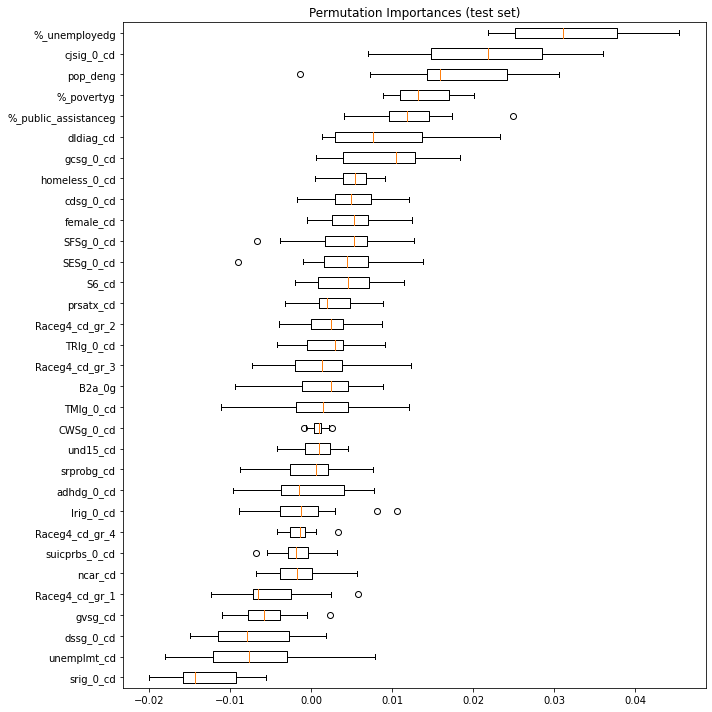

In [13]:
%%time

# permutation importance

result = permutation_importance(rfc, X_test, y_test, scoring='roc_auc', n_repeats=20)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [14]:
# mean decrease in impurity

mdi = rfc.feature_importances_
feature_importance_rf = pd.DataFrame({'feature': X_test.columns, 'RF-MDI': mdi})
feature_importance_rf.sort_values(by='RF-MDI', ascending=False)

,feature,RF-MDI
11,dssg_0_cd,0.047676
15,cjsig_0_cd,0.045725
6,gvsg_cd,0.044919
12,adhdg_0_cd,0.042714
3,TRIg_0_cd,0.042110
23,B2a_0g,0.040426
20,gcsg_0_cd,0.040129
4,TMIg_0_cd,0.039910
5,SESg_0_cd,0.039450
29,%_unemployedg,0.037959


In [16]:
performance = pd.DataFrame(data=[lr_perf, rfc_perf], columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
performance

,Model,Accuracy,F1,Precision,Recall,AUC
0,LR,0.602163,0.502256,0.452575,0.564189,0.593662
1,RF,0.663462,0.360731,0.556338,0.266892,0.574677


In [17]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./raw_results/' + grouping + '_feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feature_importance_lr.to_excel(writer, sheet_name='LR')
feature_importance_rf.to_excel(writer, sheet_name='RF')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
# triggers a ctrl-s so that conversion to html will work properly

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
        
save_notebook('mvp_v2.ipynb')

In [ ]:
# save test results

now = datetime.now()
current_time = now.strftime("(%H:%M:%S)")
current_date = now.date().strftime("%b-%d")

filename = current_date + current_time + ".html"
print("saving results to " + filename)
os.system("ipython nbconvert --to html mvp_v2.ipynb")
os.rename('mvp_v2.html', "./raw_results/" + filename)